In [1]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import os
import dash
from dash import html, dcc, Output, Input, Dash
import plotly.graph_objects as go
from matplotlib.patches import Rectangle, Circle, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import matplotlib

In [9]:
def open_json(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
        return data

def sanity_check(data, file):
    required_keys = {
        'id_app',
        'link',
        'description',
        'name',
        'installation_count',
        #'services_name',
        'trigger',
        'action',
        'permissions_trigger',
        'permissions_action',
        'node_color'
    }

    invalid_keys = [k for k in required_keys if not data.get(k)]
    if invalid_keys:
        print(f"Empty or None values in file {file}: {invalid_keys}")

############################# DATA EXTRACTION
def extract_fine_grained(data):
    fine_grained_triggers = data['data']['applet']['trigger']['ingredients']
    fine_grained_trigger_endpoints = {}
    for fine_grained_trigger in fine_grained_triggers:
        name = fine_grained_trigger['slug'].lower()
        if name not in fine_grained_trigger_endpoints:
            fine_grained_trigger_endpoints[name] = []
        fine_grained_trigger_endpoints[name].append(fine_grained_trigger['normalized_name'].lower())
    fine_grained_action_endpoints = {}
    #fine_grained_actions = data['appletDetails']['normalized_applet']['stored_fields']
    fine_grained_actions = data['data']['applet']['actions'][0]['action_fields']
    for fine_grained_action in fine_grained_actions:
        name = fine_grained_action['normalized_module_name']
        if name not in fine_grained_action_endpoints:
            fine_grained_action_endpoints[name] = []
        endpoint = data['data']['applet']['trigger']['full_normalized_module_name'].lower() 
        fine_grained_action_endpoints[name].append(endpoint)
    return fine_grained_trigger_endpoints, fine_grained_action_endpoints    

def extract_features(json):

    app_categories = open_json(os.path.join(os.getcwd(), './data/categories_services_2025.json'))

    id_app = json['data']['applet']['id']
    link = 'https://ifttt.com/applets/'+json['data']['applet']['friendly_id']
    description = json['data']['applet']['description']
    name = json['data']['applet']['name']
    installation_count = json['data']['applet']['installs_count']
    #services_name = [json['data']['applet']['channels'][0]['name'], json['data']['applet']['channels'][1]['name']]
    trigger = json['data']['applet']['channels'][0]['name']
    try:
        action = json['data']['applet']['channels'][1]['name']
    except:
        action = json['data']['applet']['channels'][0]['name']
    permissions_trigger = "/triggers/"+json['data']['applet']['trigger']['full_normalized_module_name'].lower()
    permissions_action = "/actions/"+json['data']['applet']['actions'][0]['full_normalized_module_name'].lower()
    node_color = '#'+json['data']['applet']['channels'][0]['brand_color']
    fine_grained_trigger = extract_fine_grained(json)[0]
    fine_grained_action = extract_fine_grained(json)[1]
    return {
        'id_app': id_app,
        'link': link,
        'description': description,
        'name': name,
        'installation_count': installation_count,
        #'services_name': services_name,
        'trigger': trigger,
        'action': action,
        'permissions_trigger': permissions_trigger,
        'permissions_action': permissions_action,
        'node_color': node_color,
        'fine_grained_trigger': fine_grained_trigger,
        'fine_grained_action': fine_grained_action,
        'data_category_trigger': get_data_category(app_categories, permissions_trigger),
        'data_category_action': get_data_category(app_categories, permissions_action)
    }

def get_data_category(app_categories, node_permission):
    data_category = 'unknown'
    service = node_permission[node_permission.find('/', node_permission.find('/')+1):node_permission.find('.', node_permission.find('/', node_permission.find('/')+1))].replace('/', '').lower()
    for c, s in app_categories.items():
        s = [item.replace('_', '') for item in s]
        if service in s:
            data_category = c
    return data_category

def get_privacy_policy(service):
    if " " in service:
        service = service.split(" ")[0]
    file_path = f'./data/privacy_policy/{service}.txt'
    
    if not os.path.exists(file_path):
        return html.P("Privacy policy not available.")

    with open(file_path, 'r') as f:
        text = f.read()

    lines = text.splitlines()
    bullet_lines = []
    paragraph_lines = []

    for line in lines:
        stripped = line.strip()
        if stripped.startswith(("•", "*", "-")):
            bullet_lines.append(stripped.lstrip("•*- ").strip())
        elif stripped:
            paragraph_lines.append(stripped)

    elements = []

    if paragraph_lines:
        for para in paragraph_lines:
            elements.append(html.P(para))

    if bullet_lines:
        elements.append(html.Ul([html.Li(bullet) for bullet in bullet_lines]))

    return html.Div(elements)

############################ GRAPH CREATION
def new_node(G, data, node):
    if node in data['trigger'] or node in data['id_app'] or node in data['data_category_trigger']:
        G.add_node(node, 
                   id_app=[data['id_app']], 
                   url=[data['link']],
                   description=[data['description']],
                   installation_count=[str(abs(int(data['installation_count'])))],
                   color=data['node_color'],
                   trigger=[data['trigger']],
                   action=[data['action']],
                   permission =[data['permissions_trigger']],
                   fine_grained_trigger=[data['fine_grained_trigger']],
                   fine_grained_action=[data['fine_grained_action']],
                   data_category=[data['data_category_trigger']])      
    elif node in data['action'] or node in data['data_category_action']:
        G.add_node(node, 
                   id_app=[data['id_app']], 
                   url=[data['link']],
                   description=[data['description']],
                   installation_count=[str(abs(int(data['installation_count'])))],
                   color=data['node_color'],
                   trigger=[data['trigger']],
                   action=[data['action']],
                   permission=[data['permissions_action']],
                   fine_grained_trigger=[data['fine_grained_trigger']],
                   fine_grained_action=[data['fine_grained_action']],
                   data_category=[data['data_category_action']])
    return G

def update_node(G, data, node):
    if node in data['trigger'] or node in data['id_app'] or node in data['data_category_trigger']:
        G.nodes[node]['id_app'].append(data['id_app'])
        G.nodes[node]['url'].append(data['link'])
        G.nodes[node]['description'].append(data['description'])
        G.nodes[node]['installation_count'].append(str(abs(int(data['installation_count']))))
        G.nodes[node]['color'] = data['node_color']
        G.nodes[node]['trigger'].append(data['trigger'])
        G.nodes[node]['action'].append(data['action'])
        G.nodes[node]['permission'].append(data['permissions_trigger'])
        G.nodes[node]['fine_grained_trigger'].append(data['fine_grained_trigger'])
        G.nodes[node]['fine_grained_action'].append(data['fine_grained_action'])
        G.nodes[node]['data_category'].append(data['data_category_trigger'])
    if node in data['action'] or node in data['data_category_action']:
        G.nodes[node]['id_app'].append(data['id_app'])
        G.nodes[node]['url'].append(data['link'])
        G.nodes[node]['description'].append(data['description'])
        G.nodes[node]['installation_count'].append(str(abs(int(data['installation_count']))))
        G.nodes[node]['color'] = data['node_color']
        G.nodes[node]['trigger'].append(data['trigger'])
        G.nodes[node]['action'].append(data['action'])
        G.nodes[node]['permission'].append(data['permissions_action'])
        G.nodes[node]['fine_grained_trigger'].append(data['fine_grained_trigger'])
        G.nodes[node]['fine_grained_action'].append(data['fine_grained_action'])
        G.nodes[node]['data_category'].append(data['data_category_action'])
    return G

def create_graph(app_list):
    G = nx.DiGraph()
    for data in app_list:
        for node in [data['trigger'], data['action'], data['id_app'], data['data_category_trigger'], data['data_category_action']]:
            if node not in G.nodes:
                G = new_node(G, data, node)
            else:
                G = update_node(G, data, node)
                
        G.add_edge(data['trigger'], data['id_app'], label='trigger', id_app=data['id_app'])
        G.add_edge(data['id_app'], data['action'], label='action', id_app=data['id_app'])
        G.add_edge(data['id_app'], data['data_category_trigger'], label='type', id_app=data['id_app'])

    return G

############################ EXPORTING GRAPH
def export_graph_to_json(G, pos, filename="figma_data.json"):
    data = {
        "nodes": [],
        "edges": []
    }

    for node, attr in G.nodes(data=True):
        node_data = {
            "id_app": attr.get("id_app", []),
            "service": node,
            "position": {"x": pos[node][0], "y": pos[node][1]},
            "url": attr.get("url", []),
            "description": attr.get("description", []),
            "installation_count": attr.get("installation_count", []),
            "color": attr.get("color", "#000000"),
            "trigger": attr.get("trigger", []),
            "action": attr.get("action", []),
            "permission": attr.get("permission", [])
        }
        data["nodes"].append(node_data)

    for source, target, edge_attr in G.edges(data=True):
        data["edges"].append({
            "source": source,
            "target": target,
            "label": edge_attr.get("label", "")
        })

    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)

def network_metrics(graph: nx.Graph) -> None:

    """
    this function print out some network metrics
    comment and uncomment print line are due to the fact that some of these metrics are strictly related
    to a directional or undirectional network (connections between nodes)
    """    

    #max_de = max(nx.degree_centrality(graph).items(), key=itemgetter(1))
    #max_clo = max(nx.closeness_centrality(graph).items(), key=itemgetter(1))
    #max_bet = max(nx.betweenness_centrality(graph, normalized=True, endpoints=False).items(), key=itemgetter(1))
    #print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
    #print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
    #print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

    information = {}
    information['total_nodes'] = graph.number_of_nodes()
    information['total_edges'] = graph.number_of_edges()
    print('total_nodes', information['total_nodes'])
    print('total_edges', information['total_edges'])
    information['max_in_degree'] = sorted(dict(graph.in_degree()).items(), key=lambda kv: kv[1], reverse=True)[:1]
    information['max_out_degree'] = sorted(dict(graph.out_degree()).items(), key=lambda kv: kv[1], reverse=True)[:1]
    print('max_in_degree', information['max_in_degree'])
    print('max_out_degree', information['max_out_degree'])
    information['max_degree_centrality'] = sorted(dict(nx.degree_centrality(graph).items()), key=lambda kv: kv[1], reverse=True)[:1]
    information['max_closeness_centrality'] = sorted(dict(nx.closeness_centrality(graph).items()), key=lambda kv: kv[1], reverse=True)[:1]
    information['max_betweenness_centrality'] = sorted(dict(nx.betweenness_centrality(graph, normalized=True, endpoints=False).items()), key=lambda kv: kv[1], reverse=True)[:1]
    information['pagerank'] = sorted(dict(nx.pagerank(graph).items()), key=lambda kv: kv[1], reverse=True)[:10]
    return information

def draw_graph(G):
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, k=2, seed=42)
    edge_labels = nx.get_edge_attributes(G, 'label')
    def is_dark_color(color):
        rgb = matplotlib.colors.to_rgb(color)
        luminance = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
        return luminance < 0.2
    [G.nodes[node].update({'color': '#8cc251'}) for node in G.nodes() if G.nodes[node].get('color', '#8cc251').lower() == 'black' or is_dark_color(G.nodes[node].get('color', '#8cc251'))]
    node_colors = [G.nodes[node].get('color', '#8cc251') for node in G.nodes()]
    nx.draw(
        G, pos, with_labels=True,
        node_color=node_colors,
        node_size=2000,
        font_size=10,
        arrows=True
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.show()

### GRAPH OPERATIONS
def extract_subgraph(G, node, depth_limit=2, draw=False):
    """
    Extracts a subgraph from G starting from the given node and going up to the specified depth limit.
    """
    sub = G.subgraph(list(nx.bfs_tree(G, node, depth_limit=depth_limit).nodes()))
    if draw:
        draw_graph(sub)
    return list(sub)

### INTERFACE
NODE_IMAGE_MAP = {
    "Spotify": "https://cdn-icons-png.flaticon.com/512/174/174872.png",
    "Gmail": "https://cdn-icons-png.flaticon.com/512/281/281769.png",
    "Google Calendar": "https://cdn-icons-png.flaticon.com/512/732/732208.png",
    "YouTube": "https://cdn-icons-png.flaticon.com/512/1384/1384060.png",
    "Google": "https://cdn-icons-png.flaticon.com/128/300/300221.png",
    "Twitter": "https://cdn-icons-png.flaticon.com/128/733/733579.png",
    "Philips Hue": "https://cdn-icons-png.flaticon.com/128/882/882703.png",
    "Facebook": "https://cdn-icons-png.flaticon.com/128/145/145802.png",
    "IFTTT": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADhCAMAAAAJbSJIAAAAZlBMVEUiIiL///8eHh45OTn39/cAAAAMDAycnJwYGBhlZWXS0tLl5eUSEhJzc3MWFhba2tp9fX27u7urq6szMzNtbW20tLTo6Ojz8/NoaGgnJycvLy/MzMxwcHCfn59gYGCmpqZDQ0OPj48ISkAWAAAByklEQVR4nO3a23KaUACGUUChmHhMjFarObz/SwZbSLdKN07DtBlmravo/AJfvDGRJAEAAAAAAAAAAAAAAAAAAAAAAAAABiwLtTx1oXNw0yS7cdJL4OMo8POwu1HErhrsY4PRaN91jPpEN0z6kP9Ixx8WRfVMOQmeuZQ+l0nxEBlUk5ciKdfRyfg+r361m+gkzfsqvEt/u89/FUZUhflTbJCmD0UyX8cnm1PhNr5RqFChQoUKFf6/wklVuOouPMQn21Ph+GsUrr6dOb5mSXk41o9Wbcvjukyy12byEk4WzWHeptVH17fm0SZs/zhT8Y8KZ3lx5vR5uKx/zpfhct0sy2qSNZN9+E6tmsn0dOpps1mcXUJzpp4COwuX8z+/dnpWOGtbZqPzwtZLOCuc9tMVHL7zPSwbV68dRuFx8r22fhxmYWBy+S4OrvBZoUKFChUqVKhwAIUD/dR2PMxqy6vvSoZROMvnjasvg4ZROPy/gBUqVJgo/DSFAyiM34vRft21+TJcHtoLt8Hkqb3wLrgFYxE539/pup9mF3vxLctwcvUf15ZL+GRP2/Hj90Td/uJ+Jr3dCgUAAAAAAAAAAAAAAAAAAAAAAAAAfGnvTgE7sIf2uvsAAAAASUVORK5CYII=",
    "Instagram": "https://cdn-icons-png.flaticon.com/128/3955/3955024.png",
    "Android SMS": "https://cdn-icons-png.flaticon.com/128/226/226770.png",
    "Android Device": "https://cdn-icons-png.flaticon.com/128/226/226770.png",
    "Android Photos": "https://cdn-icons-png.flaticon.com/128/226/226770.png",
    "Android Phone Call": "https://cdn-icons-png.flaticon.com/128/226/226770.png",
    "iOS Contacts": "https://cdn-icons-png.flaticon.com/128/731/731985.png",
    "iOS Photos": "https://cdn-icons-png.flaticon.com/128/731/731985.png",
    "Google Drive": "https://cdn-icons-png.flaticon.com/128/5968/5968523.png",
    "Google Contacts": "https://cdn-icons-png.flaticon.com/128/720/720236.png",
    "Google Sheets": "https://cdn-icons-png.flaticon.com/128/281/281761.png",
    "Weather Underground": "https://cdn-icons-png.flaticon.com/128/1163/1163661.png",
    "RSS Feed": "https://cdn-icons-png.flaticon.com/128/3670/3670120.png",
    "VoIP Calls": "https://cdn-icons-png.flaticon.com/128/1674/1674983.png",
    "Space": "https://cdn-icons-png.flaticon.com/128/1067/1067357.png",
    "Notifications": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADhCAMAAAAJbSJIAAAAZlBMVEUiIiL///8eHh45OTn39/cAAAAMDAycnJwYGBhlZWXS0tLl5eUSEhJzc3MWFhba2tp9fX27u7urq6szMzNtbW20tLTo6Ojz8/NoaGgnJycvLy/MzMxwcHCfn59gYGCmpqZDQ0OPj48ISkAWAAAByklEQVR4nO3a23KaUACGUUChmHhMjFarObz/SwZbSLdKN07DtBlmravo/AJfvDGRJAEAAAAAAAAAAAAAAAAAAAAAAAAABiwLtTx1oXNw0yS7cdJL4OMo8POwu1HErhrsY4PRaN91jPpEN0z6kP9Ixx8WRfVMOQmeuZQ+l0nxEBlUk5ciKdfRyfg+r361m+gkzfsqvEt/u89/FUZUhflTbJCmD0UyX8cnm1PhNr5RqFChQoUKFf6/wklVuOouPMQn21Ph+GsUrr6dOb5mSXk41o9Wbcvjukyy12byEk4WzWHeptVH17fm0SZs/zhT8Y8KZ3lx5vR5uKx/zpfhct0sy2qSNZN9+E6tmsn0dOpps1mcXUJzpp4COwuX8z+/dnpWOGtbZqPzwtZLOCuc9tMVHL7zPSwbV68dRuFx8r22fhxmYWBy+S4OrvBZoUKFChUqVKhwAIUD/dR2PMxqy6vvSoZROMvnjasvg4ZROPy/gBUqVJgo/DSFAyiM34vRft21+TJcHtoLt8Hkqb3wLrgFYxE539/pup9mF3vxLctwcvUf15ZL+GRP2/Hj90Td/uJ+Jr3dCgUAAAAAAAAAAAAAAAAAAAAAAAAAfGnvTgE7sIf2uvsAAAAASUVORK5CYII=",
    "Location": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADhCAMAAAAJbSJIAAAAZlBMVEUiIiL///8eHh45OTn39/cAAAAMDAycnJwYGBhlZWXS0tLl5eUSEhJzc3MWFhba2tp9fX27u7urq6szMzNtbW20tLTo6Ojz8/NoaGgnJycvLy/MzMxwcHCfn59gYGCmpqZDQ0OPj48ISkAWAAAByklEQVR4nO3a23KaUACGUUChmHhMjFarObz/SwZbSLdKN07DtBlmravo/AJfvDGRJAEAAAAAAAAAAAAAAAAAAAAAAAAABiwLtTx1oXNw0yS7cdJL4OMo8POwu1HErhrsY4PRaN91jPpEN0z6kP9Ixx8WRfVMOQmeuZQ+l0nxEBlUk5ciKdfRyfg+r361m+gkzfsqvEt/u89/FUZUhflTbJCmD0UyX8cnm1PhNr5RqFChQoUKFf6/wklVuOouPMQn21Ph+GsUrr6dOb5mSXk41o9Wbcvjukyy12byEk4WzWHeptVH17fm0SZs/zhT8Y8KZ3lx5vR5uKx/zpfhct0sy2qSNZN9+E6tmsn0dOpps1mcXUJzpp4COwuX8z+/dnpWOGtbZqPzwtZLOCuc9tMVHL7zPSwbV68dRuFx8r22fhxmYWBy+S4OrvBZoUKFChUqVKhwAIUD/dR2PMxqy6vvSoZROMvnjasvg4ZROPy/gBUqVJgo/DSFAyiM34vRft21+TJcHtoLt8Hkqb3wLrgFYxE539/pup9mF3vxLctwcvUf15ZL+GRP2/Hj90Td/uJ+Jr3dCgUAAAAAAAAAAAAAAAAAAAAAAAAAfGnvTgE7sIf2uvsAAAAASUVORK5CYII=",
    "Button widget": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADhCAMAAAAJbSJIAAAAZlBMVEUiIiL///8eHh45OTn39/cAAAAMDAycnJwYGBhlZWXS0tLl5eUSEhJzc3MWFhba2tp9fX27u7urq6szMzNtbW20tLTo6Ojz8/NoaGgnJycvLy/MzMxwcHCfn59gYGCmpqZDQ0OPj48ISkAWAAAByklEQVR4nO3a23KaUACGUUChmHhMjFarObz/SwZbSLdKN07DtBlmravo/AJfvDGRJAEAAAAAAAAAAAAAAAAAAAAAAAAABiwLtTx1oXNw0yS7cdJL4OMo8POwu1HErhrsY4PRaN91jPpEN0z6kP9Ixx8WRfVMOQmeuZQ+l0nxEBlUk5ciKdfRyfg+r361m+gkzfsqvEt/u89/FUZUhflTbJCmD0UyX8cnm1PhNr5RqFChQoUKFf6/wklVuOouPMQn21Ph+GsUrr6dOb5mSXk41o9Wbcvjukyy12byEk4WzWHeptVH17fm0SZs/zhT8Y8KZ3lx5vR5uKx/zpfhct0sy2qSNZN9+E6tmsn0dOpps1mcXUJzpp4COwuX8z+/dnpWOGtbZqPzwtZLOCuc9tMVHL7zPSwbV68dRuFx8r22fhxmYWBy+S4OrvBZoUKFChUqVKhwAIUD/dR2PMxqy6vvSoZROMvnjasvg4ZROPy/gBUqVJgo/DSFAyiM34vRft21+TJcHtoLt8Hkqb3wLrgFYxE539/pup9mF3vxLctwcvUf15ZL+GRP2/Hj90Td/uJ+Jr3dCgUAAAAAAAAAAAAAAAAAAAAAAAAAfGnvTgE7sIf2uvsAAAAASUVORK5CYII=",
    "Date & Time": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADhCAMAAAAJbSJIAAAAZlBMVEUiIiL///8eHh45OTn39/cAAAAMDAycnJwYGBhlZWXS0tLl5eUSEhJzc3MWFhba2tp9fX27u7urq6szMzNtbW20tLTo6Ojz8/NoaGgnJycvLy/MzMxwcHCfn59gYGCmpqZDQ0OPj48ISkAWAAAByklEQVR4nO3a23KaUACGUUChmHhMjFarObz/SwZbSLdKN07DtBlmravo/AJfvDGRJAEAAAAAAAAAAAAAAAAAAAAAAAAABiwLtTx1oXNw0yS7cdJL4OMo8POwu1HErhrsY4PRaN91jPpEN0z6kP9Ixx8WRfVMOQmeuZQ+l0nxEBlUk5ciKdfRyfg+r361m+gkzfsqvEt/u89/FUZUhflTbJCmD0UyX8cnm1PhNr5RqFChQoUKFf6/wklVuOouPMQn21Ph+GsUrr6dOb5mSXk41o9Wbcvjukyy12byEk4WzWHeptVH17fm0SZs/zhT8Y8KZ3lx5vR5uKx/zpfhct0sy2qSNZN9+E6tmsn0dOpps1mcXUJzpp4COwuX8z+/dnpWOGtbZqPzwtZLOCuc9tMVHL7zPSwbV68dRuFx8r22fhxmYWBy+S4OrvBZoUKFChUqVKhwAIUD/dR2PMxqy6vvSoZROMvnjasvg4ZROPy/gBUqVJgo/DSFAyiM34vRft21+TJcHtoLt8Hkqb3wLrgFYxE539/pup9mF3vxLctwcvUf15ZL+GRP2/Hj90Td/uJ+Jr3dCgUAAAAAAAAAAAAAAAAAAAAAAAAAfGnvTgE7sIf2uvsAAAAASUVORK5CYII=",
    "Email": "https://cdn-icons-png.flaticon.com/128/3178/3178158.png"

}

def create_edges_and_annotations(G, pos):
    edge_trace = []
    annotations = []

    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]

        # Line trace for edge
        edge_trace.append(go.Scatter(
            x=[x0, x1, None], y=[y0, y1, None],
            line=dict(width=1, color='gray'),
            mode='lines',
            hoverinfo='none'
        ))

        # Arrow shape
        annotations.append(dict(
            ax=x0, ay=y0,
            x=x1, y=y1,
            xref='x', yref='y',
            axref='x', ayref='y',
            showarrow=True,
            arrowhead=3,
            arrowsize=1,
            arrowwidth=1.5,
            opacity=0.7
        ))

        # Edge label
        label = G.edges[edge].get('label', '')
        mid_x, mid_y = (x0 + x1) / 2, (y0 + y1) / 2
        annotations.append(dict(
            x=mid_x, y=mid_y,
            text=label,
            showarrow=False,
            font=dict(size=10, color="red"),
            xanchor="center",
            yanchor="bottom"
        ))

    return edge_trace, annotations

def create_node_trace(G, pos):
    node_x, node_y, node_text, node_ids, node_colors = [], [], [], [], []

    for node, attrs in G.nodes(data=True):
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)
        node_ids.append(node)
        node_colors.append(attrs.get('color', '#1f77b4'))
        #node_colors.append('#FFFFFF')
    return go.Scatter(
        x=node_x,
        y=node_y,
        mode='markers+text',
        text=node_text,
        textposition="top center",
        hoverinfo='text', #WHEN YOU GO OVER A NODE, SHOW ALL INFO
        marker=dict(
            size=20,
            color=node_colors,
            line=dict(width=2, color='black')
        ),
        customdata=node_ids
    )

def create_node_images(pos, icon_map, size=0.12):
    node_images = []

    for node, (x, y) in pos.items():
        if node in icon_map:
            node_images.append(dict(
                source=icon_map[node],
                xref="x",
                yref="y",
                x=x - size / 5,  # Center horizontally
                y=y,# + size / 2,  # Move up slightly to sit above
                sizex=size,
                sizey=size,
                xanchor="left",
                yanchor="middle",
                layer="above"
            ))
    return node_images

def create_dash_layout(edge_trace, node_trace, annotations, node_images):
    return html.Div([
        html.H2("IFTTT Graph: Trigger → Action", style={"textAlign": "center"}),
        dcc.Graph(
            id='network-graph',
            figure={
                'data': edge_trace + [node_trace],
                'layout': go.Layout(
                    clickmode='event+select',
                    showlegend=False,
                    margin=dict(l=20, r=20, t=20, b=20),
                    hovermode='closest',
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    annotations=annotations,
                    images=node_images  # ← added image layer
                )
            },
            style={"height": "600px"}
        ),
        html.Div(id='node-info', style={"padding": "10px", "fontSize": "16px"}),
    ])

def display_node_info(G, clickData, graph_info):
    if clickData and 'customdata' in clickData['points'][0]:
        node = clickData['points'][0]['customdata']
        data = G.nodes[node]

        id_apps = data.get('id_app', [])
        urls = data.get('url', [])
        descriptions = data.get('description', [])
        installs = data.get('installation_count', [])
        triggers = data.get('trigger', [])
        actions = data.get('action', [])
        permissions = data.get('permission', [])
        fine_grained_triggers = data.get("fine_grained_trigger", {})
        fine_grained_actions = data.get("fine_grained_action", {})
        data_types = data.get("data_category", [])

        combined_info = []

        def format_field_list(fields):
            if not fields:
                return ""
            elif len(fields) == 1:
                return fields[0]
            else:
                return ", ".join(fields[:-1]) + f", and {fields[-1]}"

        for i, (app_id, link, desc, count, trigger, action, permission, fg_trigger, fg_action, data_type) in enumerate(zip(
            id_apps, urls, descriptions, installs, triggers, actions, permissions,
            fine_grained_triggers, fine_grained_actions, data_types
        )):

            trigger_fields = list(fg_trigger.keys())
            action_fields = list(fg_action.keys())
            trigger_fields_readable = [field.replace('_', ' ').capitalize() for field in trigger_fields]
            action_fields_readable = [field.replace('_', ' ').capitalize() for field in action_fields]

            if permission.count('/') > 2:
                permission = permission.split('/')[:3]
                permission = '/'.join(permission)

            # Build the sharing sentence
            if trigger_fields_readable or action_fields_readable:
                trigger_str = format_field_list(trigger_fields_readable)
                action_str = format_field_list(action_fields_readable)
                sharing_sentence = html.Span(["This app uses the '", html.Strong(trigger.title()), "' trigger, sharing ", trigger_str.lower(), ", which is used in the '", html.Strong(action.title()), "' action involving ", action_str.lower(), "."])
            else:
                sharing_sentence = "No fine-grained data available."


            combined_info.append(html.Div([
                html.P(f"Data Category: {data_type.replace('-', ' ').title()}"),
                html.P(f"Purpose: {desc}"),
                html.P(f"Usage: {count} users"),
                #html.P(f"Trigger: {trigger}"),
                #html.P(f"Action: {action}"),
                html.P(["Fine Grained Data Sharing: ", sharing_sentence]),
                #html.P(f"Endpoint: {permission}"),
                html.A("Original Applet Link", href=link, target="_blank"),
                #html.P(f"App ID: {app_id}"),
            ], style={"marginBottom": "15px", "borderBottom": "1px solid #ccc"}))

        applet_list = html.Div([
            html.P(f"{node} is involved in the following App(s):"),
            *[html.P([f"• {app_id} – ", html.A("check on IFTTT", href=f"https://ifttt.com/applets/{app_id}", target="_blank")]) for app_id in id_apps]
        ], style={"marginTop": "20px", "borderBottom": "1px solid #ccc"})

        privacy_policy = html.Div([
            html.P(html.B("Privacy Policy:")), 
            html.P(get_privacy_policy(node))
        ], style={"marginTop": "20px"})

        return [html.H4(f"Node: {node}")] + combined_info + [applet_list, privacy_policy]

    return html.Div([
        html.P("Click on a node to see its details, including the applets it is involved in and the data it shares."),
        html.P(f"The mostly involved trigger node is {graph_info['max_in_degree'][0][0]} with {graph_info['max_in_degree'][0][1]} connections."),
        html.P(f"The mostly involved action node is {graph_info['max_out_degree'][0][0]} with {graph_info['max_out_degree'][0][1]} connections.")
])

def partition_subgraph(G):

    triggers_actions, id_apps, data_cat = set(), set(), set()

    for node in G.nodes():
        for class_ in G.nodes[node]['trigger'] or G.nodes[node]['action'] or G.nodes[node]['id_app'] or G.nodes[node]['data_category']:
            if node in G.nodes[node]['trigger'] or node in G.nodes[node]['action']:
                triggers_actions.add(node)
            #elif node in G.nodes[node]['action'] and node not in G.nodes[node]['trigger']:
            #    actions.add(node)
            #elif node in G.nodes[node]['trigger'] and node in G.nodes[node]['action']:
            #    triggers_actions.add(node)
            elif node in G.nodes[node]['id_app']:
                id_apps.add(node)
            elif node in G.nodes[node]['data_category']:
                data_cat.add(node)
    #print('Triggers:', len(triggers), '\nActions:', len(actions), '\nTriggers and Actions:', len(triggers_actions), '\nID Apps:', len(id_apps), '\nData Categories:', len(data_cat))

    G_triggers_actions = G.subgraph(triggers_actions)
    G_id_apps = G.subgraph(id_apps)
    G_data_cat = G.subgraph(data_cat)
    return G_triggers_actions, G_id_apps, G_data_cat

def layout_by_grouping(graphs, layout='vertical', figsize=(7, 4), colors=('lightblue', 'lightgreen', 'salmon')):
    fig_w, fig_h = figsize
    n = len(graphs)
    pos, node_colors = {}, {}

    for i, G in enumerate(graphs):
        if layout == 'vertical':
            column_width = fig_w / n
            x = column_width * (i + 0.5)
            y_spacing = fig_h / (len(G.nodes) + 1)
            for j, node in enumerate(G.nodes()):
                y = fig_h - (j + 1) * y_spacing
                pos[node] = (x, y)
                node_colors[node] = colors[i]
        else:  # horizontal
            row_height = fig_h / n
            y = fig_h - row_height * (i + 0.5)
            x_spacing = fig_w / (len(G.nodes) + 1)
            for j, node in enumerate(G.nodes()):
                x = (j + 1) * x_spacing
                pos[node] = (x, y)
                node_colors[node] = colors[i]

    return pos, node_colors

def create_node_patches(G, pos, node_widths, node_heights, node_colors, node_alphas, node_shape='rectangle'):
    patches = []
    facecolors = []
    edgecolors = []

    for node, (x, y) in pos.items():
        width = node_widths[node]
        height = node_heights[node]
        color = node_colors.get(node, 'lightgray') if node_colors else 'lightgray'
        alpha = node_alphas[node]

        if node_shape == 'rectangle':
            patch = Rectangle((x - width / 2, y - height / 2), width, height)
        elif node_shape == 'triangle':
            triangle = [
                (x, y + height / 2),  # top
                (x - width / 2, y - height / 2),  # bottom left
                (x + width / 2, y - height / 2)   # bottom right
            ]
            patch = Polygon(triangle, closed=True)
        else:
            radius = width / 2
            patch = Circle((x, y), radius=radius)

        patches.append(patch)
        facecolors.append(color)
        edgecolors.append('black')

    rgba_facecolors = [
        mcolors.to_rgba(color, alpha=node_alphas[node])
        for node, color in zip(G.nodes(), facecolors)
    ]

    collection = PatchCollection(
        patches,
        facecolors=rgba_facecolors,
        edgecolors=edgecolors
    )

    return collection

def get_degree_metric(G, mode):
    if mode == 'in' and G.is_directed():
        return dict(G.in_degree())
    elif mode == 'out' and G.is_directed():
        return dict(G.out_degree())
    else:
        return dict(G.degree())

def normalize(values, min_val=0.2, max_val=1.0):
    if not values:
        return {}
    low = min(values.values())
    high = max(values.values())
    if high == low:
        return {k: (min_val + max_val) / 2 for k in values}
    return {
        k: min_val + (v - low) / (high - low) * (max_val - min_val)
        for k, v in values.items()
    }

def compute_node_widths(G, scale_by, text_widths, width_range, fixed_width, padding=0.2):
    """Compute node widths, scaled or fixed based on degree and text size."""
    max_text_width = max(text_widths.values()) if text_widths else fixed_width
    min_node_width = max(max_text_width + padding, fixed_width)

    if scale_by == 'none':
        node_widths = {node: min_node_width for node in G.nodes()}
        degrees = {node: 1 for node in G.nodes()}
    else:
        degrees = get_degree_metric(G, scale_by)
        node_widths = normalize(degrees, *width_range)
        scale_factor = max(min_node_width / min(node_widths.values()), 1.0)
        node_widths = {k: v * scale_factor for k, v in node_widths.items()}

    return node_widths, degrees

def measure_text_widths(G, ax, dpi, fontsize=5):
    """Measure text width for each node label."""
    text_widths = {}
    for node in G.nodes():
        text = str(node)
        t = ax.text(0, 0, text, fontsize=fontsize)
        plt.draw()
        bb = t.get_window_extent(renderer=ax.figure.canvas.get_renderer())
        text_widths[node] = bb.width / dpi
        t.remove()
    return text_widths

def fixed_node_heights(G, fixed_height):
    return {node: fixed_height for node in G.nodes()}

def draw_graph_flexible(G, pos='orizontal', scale_by='degree',  alpha_mode='none', figsize=(20, 16), rotation=0, node_shape='rectangle', draw=False):
    """
    Draw a graph with rectangular or circular nodes, supporting size scaling and transparency.

    Parameters:
    - G: networkx Graph
    - pos: dict {node: (x, y)}
    - scale_by: 'degree' | 'in' | 'out' | 'none'
    - alpha_mode: 'none' | 'degree'
    - figsize: tuple (width, height)
    - rotation: int (range 0-360)
    - node_shape: 'rectangle' | 'circle' | 'triangle'
    - draw: bool, whether to draw the graph or just return positions
    """

    width_range = (0.4, 1.2)
    fixed_width, fixed_height = 0.6, 0.3
    fixed_alpha = 1.0

    G_triggers_actions, G_id_apps, G_data_cat = partition_subgraph(G)
    pos, node_colors = layout_by_grouping([G_data_cat, G_id_apps, G_triggers_actions], layout=pos, figsize=figsize)

    if draw:

        fig, ax = plt.subplots(figsize=figsize)
        fig.canvas.draw()
        renderer = fig.canvas.get_renderer()

        text_widths = measure_text_widths(G, ax, fig.dpi)
        node_widths, degrees = compute_node_widths(G, scale_by, text_widths, width_range, fixed_width)
        node_heights = fixed_node_heights(G, fixed_height)

        if alpha_mode == 'degree':
            node_alphas = normalize(degrees, min_val=0.2, max_val=1.0)
        elif alpha_mode == 'none':
            node_alphas = {node: fixed_alpha for node in G.nodes()}

        nx.draw_networkx_edges(G, pos, ax=ax)

        collection = create_node_patches(G, pos, node_widths, node_heights, node_colors, node_alphas, node_shape=node_shape)
        ax.add_collection(collection)

        for node, (x, y) in pos.items():
            ax.text(x, y, str(node), ha='center', va='center', fontsize=10, rotation=rotation)

        ax.set_aspect('equal')
        all_x = [x for x, y in pos.values()]
        all_y = [y for x, y in pos.values()]
        margin = 1.0
        ax.set_xlim(min(all_x) - margin, max(all_x) + margin)
        ax.set_ylim(min(all_y) - margin, max(all_y) + margin)
        plt.axis('off')
        plt.title("Graph with {} Nodes".format(node_shape.capitalize()))
        plt.show()
    
    return pos


In [ ]:
subfolder_path = os.path.join(os.getcwd(), './data/applets')
json_files = [os.path.join(root, file) for root, _, files in os.walk(subfolder_path) for file in files if file.endswith('.json')]

In [11]:
app_list = []
for file in json_files:
    app = open_json(file)
    dict_app = extract_features(app)
    sanity_check(dict_app, file)
    app_list.append(dict_app)

In [13]:
G = create_graph(app_list)
pos = nx.spring_layout(G, k=2, seed=42)
graph_info = network_metrics(G)
#export_graph_to_json(G, pos)
#draw_graph(G)

total_nodes 31
total_edges 30
max_in_degree [('Mobile devices & accessories', 7)]
max_out_degree [('pc6CeRjs', 2)]


In [14]:
#print(extract_subgraph(G, 'Twitter', depth_limit=2, draw=False))
print(len(partition_subgraph(G)[0].nodes()),
len(partition_subgraph(G)[1].nodes()),
len(partition_subgraph(G)[2].nodes()))

15 10 6


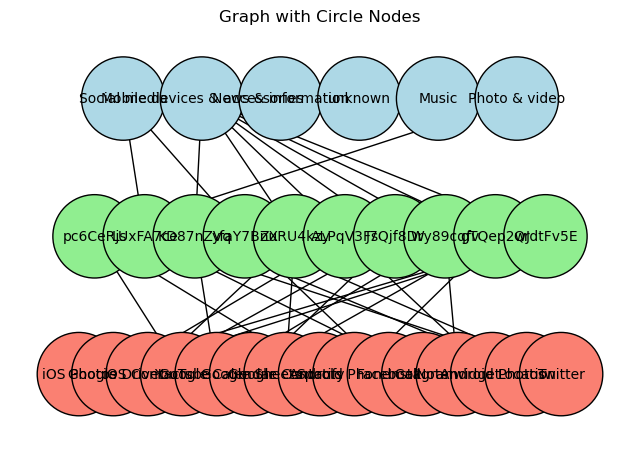

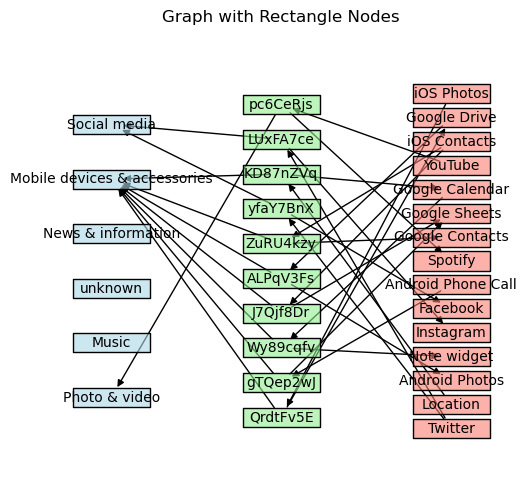

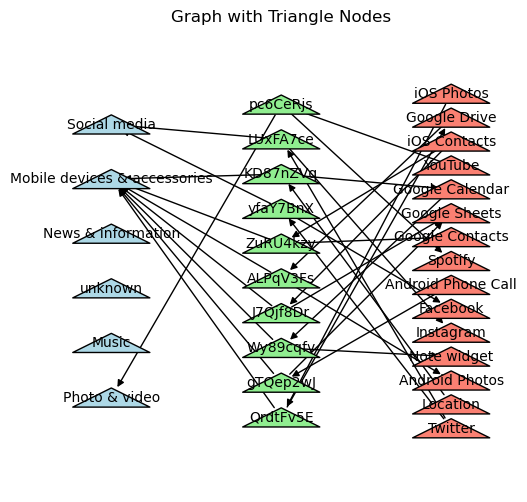

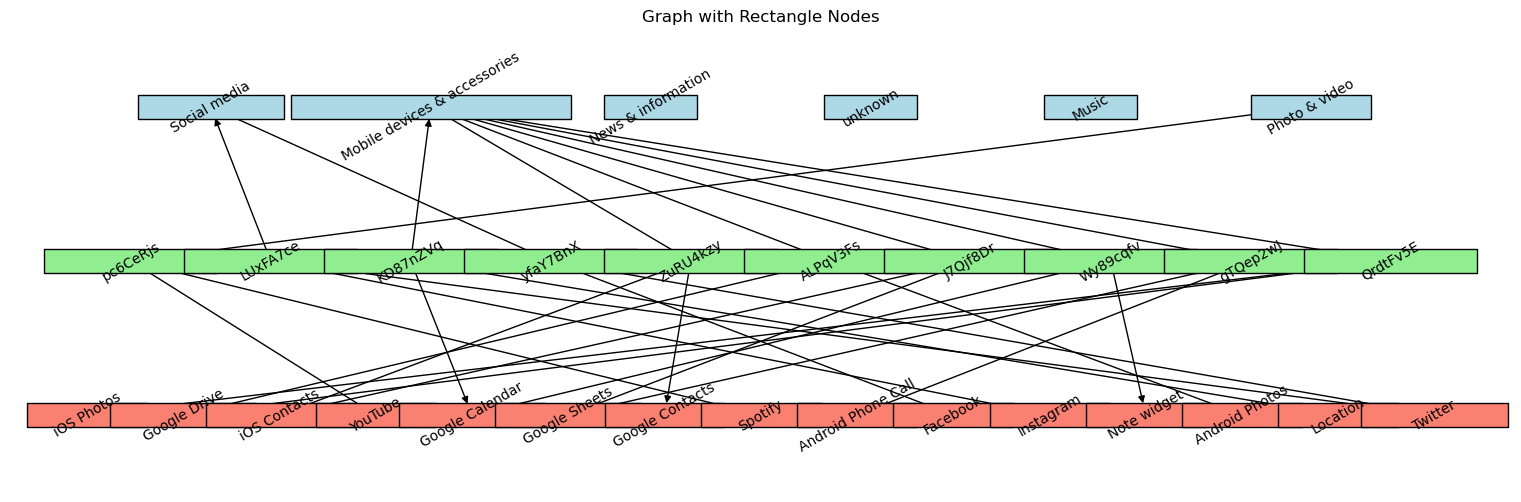

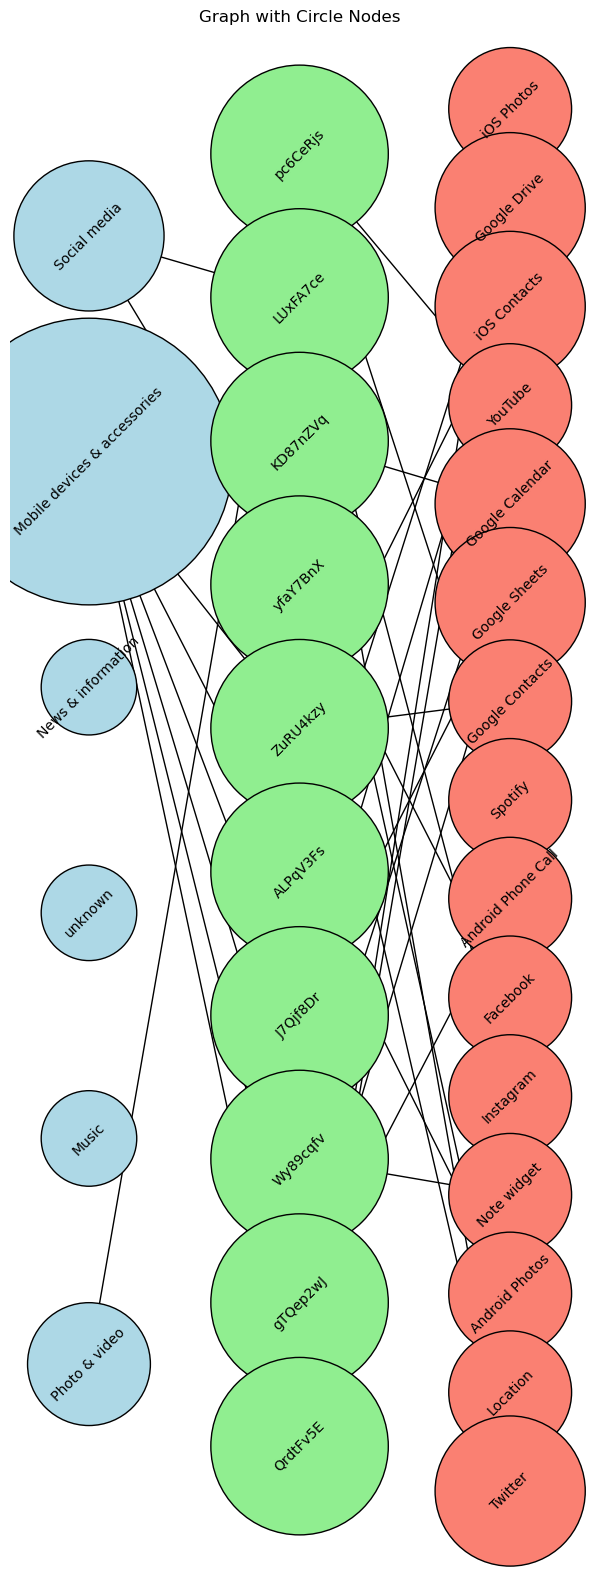

In [8]:
pos = draw_graph_flexible(G, pos='orizontal', scale_by='none', alpha_mode='none', figsize=(8, 6), rotation=0, node_shape='circle', draw=True)
pos = draw_graph_flexible(G, pos='vertical', scale_by='none', alpha_mode='degree', figsize=(8, 6), rotation=0.0, node_shape='rectangle', draw=True)
pos = draw_graph_flexible(G, pos='vertical', scale_by='none', alpha_mode='none', figsize=(8, 6), rotation=0, node_shape='triangle', draw=True)
pos = draw_graph_flexible(G, pos='orizontal', scale_by='degree', alpha_mode='none', figsize=(20, 6), rotation=30, node_shape='rectangle', draw=True)
pos = draw_graph_flexible(G, pos='vertical', scale_by='degree', alpha_mode='none', figsize=(8, 20), rotation=45, node_shape='circle', draw=True)

## APP

In [16]:
edge_trace, annotations = create_edges_and_annotations(G, pos)
node_trace = create_node_trace(G, pos)
node_images = create_node_images(pos, NODE_IMAGE_MAP)
app = Dash(__name__)
app.layout = create_dash_layout(edge_trace, node_trace, annotations, node_images)

In [17]:
@app.callback(
    Output('node-info', 'children'),
    Input('network-graph', 'clickData')
)
def callback(clickData):
    return display_node_info(G, clickData, graph_info)

if __name__ == '__main__':
    app.run(debug=True)

http://127.0.0.1:8050/
and double click on a node